# Multivariate Statistik und Machine Learning: Assignment 6
In this exercise you will learn how to use neural networs in simulated and real datasets.

Please note it is important to answer questions when they are given, as we will reduce points in case no specific answer is given.

For this we will use the [Pytorch](https://pytorch.org) library. You can install pytorch using`conda` environment or `pip` (see pytorch website).
you will also need `conda install -c pytorch torchvision`

__Team work is not allowed__. Everybody implements his/her own code. Discussing issues with others is fine, sharing code and/or answers with others is __not__. If you use any code fragments found on the Internet, make sure you reference them properly.

# Exercise 1, 1pt

In this first exercise we are going to get an idea on how simple neural networks
behave for simple classification tasks. We’ll make use of two different javascript
based neural network to train and modify an existing model. Let’s start with a very
simple one, a simple neural network with only fully connected layers and without
convolutions. Open a web browser on the page http://playground.tensorflow.org/ and start playing with the interface. For each dataset set the noise level to 30. Click play on the top-left to start training. To assess the quality of the network look at the values train and test loss at the top right. Tip: Sometimes it’s easier
to see the result if you discretise the graph.


1. For the spiral dataset try to design the best architecture you can to solve the problem.

To get the point in this task you need to add a screenshot to the submission zip file with the best architecture and answer the following:

- Now try to find an architecture that is as small as possible (low number of layers, low number of neurons), With a smaller architecture, can you keep a similar performance? You can support your answer with the test-loss numbers from the test set. 
- In the spiral dataset, do you observe any advantages of having a deep network (more layers) than a wider network (more neurons per layer)? Which one performs better in this case?

### Answer here
#### Yes, the smallest architecture with the best performance I could found was 3 hidden layers and with (8 neurons,8 neurons, 1 neuron) --> the criteria for the best performance was the robustness of this noisy data (noise = 30) in aspect to the test loss. the test loss was more or less constant around ~0.02 (which was also the smallest) with different regenerated data
#### Deeper Networks seem to converge faster and tend to less overfit but on my opinion wider networks work better in this case because the test loss seems to be lower in general in this situation


__The following part is optional, but fun!__ Open this page https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html and try to tweak all the parameters you can to obtain the best network (the highest validation accuracy).
Scroll down the page and peek inside the network and have a look at different
activation and weight as the network gets trained (click pause to make it freeze).
Check how the prediction works on the test set in the last part of the page.

# Exercise 2 Backpropagation, 3 pts

As you saw in the lecture neural networks are just a stack of simple functions, interlayered with non-linearity functions to model complex problems. Everything must be differentiable to use convex optimizers. For any of such optmizers, we need to compute gradients from the output of the network with respect to the input. Which can be easily computed using the chain rule. 

Let our neural network be defined by the function $f(x) = h_1(h_2(h_3(x)))$.

Using the chain rule we can compute 


$$ \dfrac{\partial f}{\partial x} = \dfrac{\partial h_1}{\partial h_2} \dfrac{\partial h_2}{\partial x} $$

$$ \dfrac{\partial f}{\partial x} = \dfrac{\partial h_1}{\partial h_2} \dfrac{\partial h_2}{\partial h_3}  \dfrac{\partial h_3}{\partial x}$$


let $h_1$ and $h_3$ be linear layer of the form $h_1(x) = w_1*x$ and $h_3(x) = 2*w_3*x+b_3+1$. For simplicity we will use an identity instead of a nonlinearity like ReLU or tanh.


#### Ex.3.1 Write down the partial derivatives of $h_1$ and $h_3$.

This should be done with respect to the input and each of the parameters ($x, w_1, w_3, b_3$). Here we ask you for the formula not the code.

### Answer here



$$ \dfrac{\partial h_1}{\partial x} = w_1 $$
$$ \dfrac{\partial h_1}{\partial w_1} = x $$
$$ \dfrac{\partial h_3}{\partial x} = 2 \cdot w_3 $$
$$ \dfrac{\partial h_3}{\partial w_3} = 2 \cdot x $$
$$ \dfrac{\partial h_3}{\partial b_3} = 1 $$

Such linear layers are already implemented in most common frameworks. And have automated gradient computation. In Pytorch this is called [Autograd](https://pytorch.org/docs/stable/autograd.html). In pytorch a linear function is defined in the `torch.nn.Linear` class.

Which means all the derivatives $\dfrac{\partial h_1}{\partial x}$ and $\dfrac{\partial h_3}{\partial x}$ are computed automatically with autograd.

The following code is an example implementation of a Linear function ([see source](https://pytorch.org/docs/stable/notes/extending.html)):

In [1]:
import torch
from torch import nn

In [2]:


# Inherit from Function
class LinearFunction(torch.autograd.Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if ctx.needs_input_grad[0]:
            # df/dx = w
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            # df/dw = x
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            # df/fb = 1
            grad_bias = grad_output.sum(0)
        
        
        
        return grad_input, grad_weight, grad_bias
        
        
        
linear = LinearFunction.apply

In [3]:
batch = 2
in_dim = 4
out_dim = 3

input = (torch.randn(batch,in_dim,dtype=torch.double,requires_grad=True), # input data
         torch.randn(out_dim,in_dim,dtype=torch.double,requires_grad=True),
         torch.randn(out_dim,dtype=torch.double,requires_grad=True), # bias
        )
test = torch.autograd.gradcheck(linear, input, eps=1e-6, atol=1e-4)
print(test)

True


#### Ex.2.2 Implement $h_2(x)$ in pytorch.


Stacking linear functions with non-linearities creates powerful networks to tackle complex tasks. Some times however more complicaded functions are most fitted to certain settings (e.g. physical constrains, optimization constrains, etc.). Which is why we may need to implement a more complex function in a single layer.

Let $h_2$ has the form:

$$h_2(x) =  w_{21}*x + w_{22}*x^2 +exp(w_{23}*x)+b_2$$


Use the MyFunction class skeleton below. You need to:
- write the forward pass (i.e. feed the inputs through the function using the function's parameters)
- write your own implementation of the backward pass (i.e. compute $\dfrac{\partial h_2}{\partial x}$ and return the product with the previous gradient. In our example the `grad_output` would be equivalent to $\dfrac{\partial h_1}{\partial h_2}$ and the function should return the product of `grad_output` and the gradients with respect to each of the inputs 
$(\dfrac{\partial h_1}{\partial h_2}\dfrac{\partial h_2}{\partial x},
  \dfrac{\partial h_1}{\partial h_2}\dfrac{\partial h_2}{\partial w_{21}},
  \dfrac{\partial h_1}{\partial h_2}\dfrac{\partial h_2}{\partial w_{22}},...)$. 

Note that you need to return gradients with respect to each of the inputs involved in $h_2$ in the same order the were recieved in the forward pass ($x, w_{21},w_{22},w_{23},b_{21}$).

For simplicity, asume that the input is in $\mathbb{R}^1$ and the function only outputs a single scalar. It must however be able to recieve batches of samples with the shape (batch, 1).


Hints:

- First write down the formulas of each of the partial derivatives, and then implement them. This should facilitate the writing of the code.
- `tensor_x.t()` denotes transpose of tensor_x
- for a matrix multiplication between x and y use `x.mm(y)`.
- for basic operations you can use:  `tensor_a.sum(tensor_b)` ,  `tensor_a.mul(tensor_b)`,`tensor_a.pow(2)`, `torch.exp(x)` ,  etc. ([see more](https://pytorch.org/docs/stable/tensors.html))
- it is important that the function returns pytorch tensors types.
- in case you need to create new tensors, make sure they are of type `double`, this is necessarily to make the gradcheck function work.

In [4]:
class MyFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, w21, w22=None, w23=None, b2=None):
        ctx.save_for_backward(input, w21,w22,w23,b2)
        
        output = input.mm(w21)
        if w22 is not None:
            output += w22*input.pow(2)##
        if w23 is not None:
            output += torch.exp(w23*input)##
        if b2 is not None:
            output += b2##
                 
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, w21, w22, w23, b2 = ctx.saved_tensors

        
        grad_input = grad_w21 = grad_w22 = grad_w23 = grad_b2 = None
        print(grad_output.shape, input.shape)
        grad_input = grad_output.mm(w21)
        grad_w21 = grad_output.t().mm(input)
        
        #print(w22.shape)
        if w22 is not None:
            grad_input += grad_output.mul(2*input.mm(w22))
        if w23 is not None:
            grad_input += grad_output.mul(torch.exp(input.mm(w23))*w23)
        
        
        
        if w22 is not None and ctx.needs_input_grad[2]:
            grad_w22 = grad_output.t().mm(input.pow(2))
            
        if w23 is not None and ctx.needs_input_grad[3]:
            grad_w23 = grad_output.t().mm(input.mul(torch.exp(input.mul(w23))))
        if b2 is not None and ctx.needs_input_grad[4]:
            grad_b2 = grad_output.sum(0)
        
        #print(grad_input.shape,grad_w21.shape, grad_w22.shape, grad_w23.shape, grad_b2.shape )
        
        return grad_input, grad_w21, grad_w22, grad_w23, grad_b2
myfunction = MyFunction.apply   



Using the code below you can test your implementation `gradcheck`performs a numerical computation of the gradient to verify that the analytical solution we wrote is correct.

You omit some parameters to test the gradients one by one. For example: (input, w21) will compute and check only the gradients where w21 is involved.

In [5]:
batch = 3 #2
d_in = 1
d_out = 1
input_test = (torch.randn(batch,d_in,dtype=torch.double,requires_grad=True), # input
         torch.randn(d_out,d_in,dtype=torch.double,requires_grad=True), # w21
         torch.randn(d_out,d_in,dtype=torch.double,requires_grad=False), # w22
         torch.randn(d_out,d_in,dtype=torch.double,requires_grad=True), # w23
         torch.randn(d_out,dtype=torch.double,requires_grad=True) # b21
             )

res = torch.autograd.gradcheck(myfunction, input_test, raise_exception=False)
print(res) # res should be True if the gradients are correct.



torch.Size([3, 1]) torch.Size([3, 1])
torch.Size([3, 1]) torch.Size([3, 1])
torch.Size([3, 1]) torch.Size([3, 1])
torch.Size([3, 1]) torch.Size([3, 1])
torch.Size([3, 1]) torch.Size([3, 1])
torch.Size([3, 1]) torch.Size([3, 1])
torch.Size([3, 1]) torch.Size([3, 1])
True


Example of implentation of a pytorch module using the function we just created.

In [6]:
class H2(nn.Module):
    def __init__(self, input_features, output_features, is_example=False):
        # input_features define the dimension of the input
        # output_features defines the dimensions of the output
        
        super(H2, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        
        
        self.w21 = nn.Parameter(torch.Tensor(output_features, input_features))
        self.w21.data.uniform_(-0.1, 0.1)

        if is_example:
            self.w22 = nn.Parameter(torch.Tensor(output_features, input_features))
            self.w23 = nn.Parameter(torch.Tensor(output_features, input_features))
            self.b2 = nn.Parameter(torch.Tensor(output_features))
        
            self.w22.data.uniform_(-0.1, 0.1)
            self.w23.data.uniform_(-0.1, 0.1)
            self.b2.data.uniform_(-0.1, 0.1)
        else:
            self.w22 = None
            self.w23 = None
            self.b2 = None
            

    def forward(self, input):
        
        output = myfunction(input, self.w21,self.w22,self.w23, self.b2)
        return output


In [7]:
h2 = H2(input_features=1,output_features=1, is_example=True)

In [8]:
x = torch.rand(3,1)
x_out = h2(x)

dummy_loss = x_out.sum()
dummy_loss.backward()
print(dummy_loss)

torch.Size([3, 1]) torch.Size([3, 1])
tensor(3.1018, grad_fn=<SumBackward0>)


# Exercise 3, 3pts

In this exercise you have to train a new Convolutional Neural Network from scratch for the classification of images. The aim is to achieve a high score (98%-99% accuracy on the test set) on the MNIST dataset http://yann.lecun.com/exdb/mnist/.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as datatorch
from torchvision import datasets, transforms

import sys
from tqdm import tqdm_notebook as tqdm
##if 'ipykernel' in sys.modules: <--- this statement causes an error
    ##import tqdm as tqdm_lib
    ##tqdm = tqdm_lib.notebook.tqdm 
##else:
    ##from tqdm import tqdm_notebook as tqdm
    
def plot_9_digits(MNIST_dataset):
    # plot the first 9 training images in MNIST
    fig, ax = plt.subplots(3, 3, figsize = (10, 10))
    fig.suptitle('First 9 images of MNIST')
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for x, y in [(i, j) for i in range(3) for j in range(3)]:
        ax[x, y].axis('off')
        ax[x, y].imshow(MNIST_dataset[x + y * 3][0].squeeze(), cmap = 'inferno')
        ax[x, y].set_title(MNIST_dataset[x + y * 3][1])
    plt.show()

We first load the training and test dataset:

N train samples: 60000
N test samples: 10000


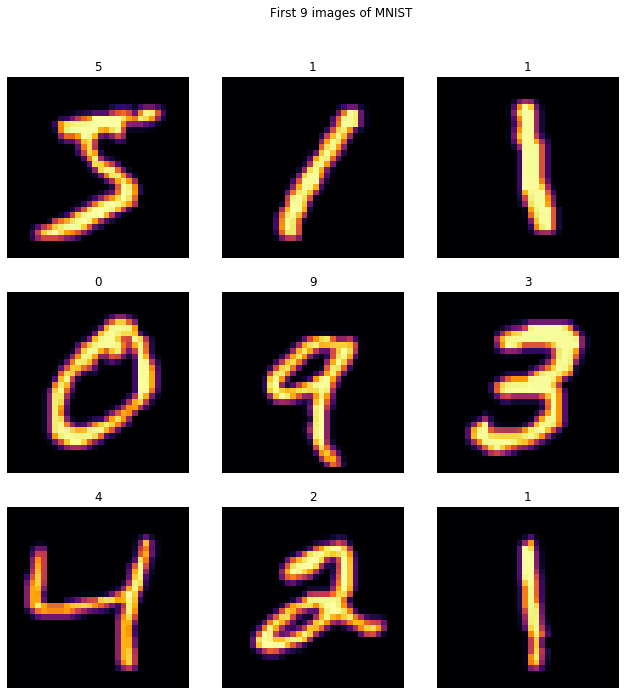

In [10]:
MNIST_train_dataset = datasets.MNIST('data', train=True, download=True,
                           transform=transforms.Compose([
                           transforms.Resize([32, 32]),
                           transforms.ToTensor()
                           ]))

MNIST_test_dataset = datasets.MNIST('data', train=False, download=True,
                           transform=transforms.Compose([
                           transforms.Resize([32, 32]),
                           transforms.ToTensor()
                           ]))


print("N train samples: {}".format(len(MNIST_train_dataset)))
print("N test samples: {}".format(len(MNIST_test_dataset)))

plot_9_digits(MNIST_train_dataset)

Define your network using `nn.sequential`. With `nn.sequential` you can simply list sequentially all the layers that form your neural network.

hints:
- the equivalent of numpy arrays are called tensors in pytorch
- pytorch processes data in batches, data have ususally 4 dimensions: [number of samples in the batch] x [number of features] x [spatial dimension] x [spatial dimension 2]
- usually the network is composed by a series of blocks each made of a sequence of: one linear layer (fully connected or convolutional layer) followed by a non-linearity (relu, tanh or sigmoid) followed by a pooling layer (average pooling or max pooling). For the MNIST dataset a set of 2-3 of such blocks should be enough.
- last layer should be a linear layer that outputs a tensor of dimension [number of samples in the batch] x [number of classes] 
- `nn.Flatten()` might be a useful module. it transforms a tensor of shape $[N,F, D_1, D_2]$ in one of dimension $[N,F\cdot D_1 \cdot D_2]$

0


1


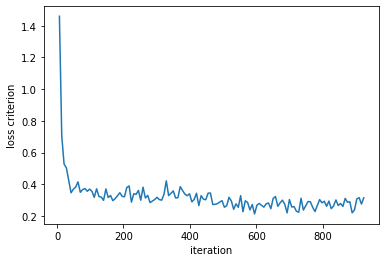

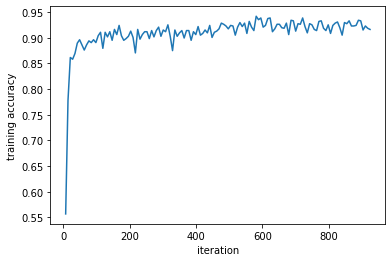

test accuracy: 0.92578125


In [11]:
number_of_classes = 10
input_channels = 1
input_spatial_dim = 32


model = nn.Sequential(#nn.Linear(32,512, bias = False),
                        #nn.ReLU(),
                        nn.Flatten(),
                        
                      nn.Linear(1024, number_of_classes, bias=False),
                        
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =model.to(device)

batch_size = 128
epochs = 2
logstep = int(1000 // batch_size)

train_loader = datatorch.DataLoader(MNIST_train_dataset,batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = datatorch.DataLoader(MNIST_test_dataset,batch_size=batch_size, shuffle=False,drop_last=True)

lr = 0.01 # learning rate
# optimizer: you can use torch.optim.SGD, torch.optim.Adam  or any other provided in pytorch lib
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

training_loss_vec = []
training_accuracy_vec = []
model.train()
for e in tqdm(range(0,epochs)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr/10**e) ## optimiser with converging learningrate
    print(e)
    training_loss = 0.
    training_accuracy = 0.
    with tqdm(train_loader,leave=False) as tnr:
        tnr.set_postfix(training_loss= np.nan,training_accuracy=np.nan)
        for n,(x,y) in enumerate(tnr):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad() #  always call this function at the beginning of each step. it basically "cleans" the computational graph
            
            y_pred =  model(x)# compute the prediction using the model
            
            loss = criterion(y_pred, y) # compute the loss using the batch labels, the predictions and the criterion
            
            # tell pytorch to compute the gradients wrt the loss
            loss.backward()
            
            # tell pytorch optimizer to make a step using the newly computed gradients
            optimizer.step()
            
            # update stats
            training_loss += loss.item()
            y_pred_idx = torch.max(y_pred.detach().cpu(),dim=1)[1]
            training_accuracy += torch.mean((y_pred_idx == y.cpu()).float()).item()
            if (n+1) % logstep == 0:
                tnr.set_postfix(training_loss=training_loss/logstep,training_accuracy=training_accuracy/logstep) 
                training_loss_vec.append(training_loss/logstep)
                training_accuracy_vec.append(training_accuracy/logstep)
                training_loss, training_accuracy = 0.,0.
                

plt.plot(logstep*np.arange(1,1+len(training_loss_vec)),np.array(training_loss_vec))
plt.ylabel("loss criterion")
plt.xlabel("iteration")
plt.show()
plt.plot(logstep*np.arange(1,1+len(training_accuracy_vec)),np.array(training_accuracy_vec))
plt.ylabel("training accuracy")
plt.xlabel("iteration")
plt.show()

test_accuracy = 0.
model.eval()
with torch.no_grad():
    for (x,y) in test_loader:
        x, y = x.to(device), y.to(device)
                
        y_pred = model(x)

        y_pred_idx = torch.max(y_pred.detach().cpu(),dim=1)[1]
        test_accuracy += torch.mean((y_pred_idx == y.cpu()).float())

    test_accuracy = test_accuracy/len(test_loader)
        
print("test accuracy: {}".format(test_accuracy))

- the `optimizer` will take care of performing the gradient descent for you, the parameter `lr` modifies the learning rate.
- choose a loss to be used for a classification task (see lecture slides and use only [pytorch loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) )

- change the architecture of the network model and the learning rate and observe how the learning curves and performance change.
- which non-linearity did you pick? do you notice big performance variation among them? (relu, sigmoid, tanh, leakyRelu...)
- How many hidden layers did your best model have? what was the feature dimension of the hidden layers?
- what accuracy on the test dataset can you achieve if you use a single linear fully connected layer on the MNIST dataset?

### Answer here
#### 2.  I picked the ReLU as a non-linearity function. Yes, there are big different up to 10% accuracy between the non-linear functions
#### 3.  2 hidden Layers with (32,512) , (16384,2)
#### 4.  I get around 92.5% test accuracy with a single linear layer


# Exercise 4 (3+2 pts)

There is a competition [https://www.kaggle.com/c/dogs-vs-cats-mvml-2020/overview](https://www.kaggle.com/c/dogs-vs-cats-mvml-2020/overview). You should create the model, train it, and upload the predictions on kaggle to get the test score on the test set. The first 3 places on the scoreboard will get 2 extra points, between the 4th and 10th place you will get 1 extra point.

In [12]:
import torch ## added
import os
import cv2
import torchvision
from torch.utils.data import Dataset
from PIL import Image
from torchvision import datasets, transforms ### added
import torch.utils.data as datatorch ### added
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split #added

In [13]:
train_dir = 'cats_vs_dogs/cats_vs_dogs'
test_dir = 'test/test'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        
        if self.mode == 'train':
            if 'dog' in self.file_list[idx]:
                label = 1
            else:
                label = 0
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), label
        else:
            img = img.numpy()
            return img.astype('float32'), int(self.file_list[idx][:-4])
        
data_transform = transforms.Compose([
    transforms.ColorJitter(),
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

data_transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

train_dataset = CatDogDataset(train_files, train_dir, transform = data_transform)
test_dataset = CatDogDataset(test_files, test_dir, mode="test" ,transform = data_transform_test)


In [14]:
print(torch.cuda.is_available())
print(train_files[0])


True
cat.0.jpg


In [15]:
# source: https://wtfleming.github.io/2020/04/12/pytorch-cats-vs-dogs-part-3/
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)


Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_master


In [16]:
##### first download the dataset and unzipped the image folders ## done

# set parameters (learning rate, batch size, number of epochs...)
learning_rate = 0.001
batch_size = 64
epochs = 20
logstep = int(1000 // batch_size)
num_workers = 0

# create dataloader for training dataset
train_loader = datatorch.DataLoader(dataset=train_dataset, 
                         shuffle=True, 
                         batch_size=batch_size)


# create network model
# source: https://wtfleming.github.io/2020/04/12/pytorch-cats-vs-dogs-part-3/
model.fc = nn.Sequential(nn.Linear(model.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, 2))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:0")
model =model.to(device)
# create optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

training_loss_vec = []
training_accuracy_vec = []

# loop over epochs
model.train()
for e in range(epochs):
    training_loss = 0.
    training_accuracy = 0.
    for n, (x,y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        #print(x.shape)
        # call optimizer.zero_grad()
        optimizer.zero_grad()
        # compute predictions using model
        y_pred =  model(x)
        # compute loss
        loss = criterion(y_pred, y)
        # run backward method
        loss.backward()
        # run optimizer step
        optimizer.step()
        scheduler.step()
        # logging (optional)
        training_loss += loss.item()
        y_pred_idx = torch.max(y_pred.detach().cpu(),dim=1)[1]
        training_accuracy += torch.mean((y_pred_idx == y.cpu()).float()).item()
        if (n+1) % logstep == 0: 
            training_loss_vec.append(training_loss/logstep)
            training_accuracy_vec.append(training_accuracy/logstep)
            print('training loss: ', training_loss/logstep,'traing_acc: ',training_accuracy/logstep)
            training_loss, training_accuracy = 0.,0.
   

# create dataloader for test dataset
# get predictions, save the file and submit it to kaggle (see the kaggle page for info on the submission)

training loss:  0.2515065977970759 traing_acc:  0.871875
training loss:  0.2265422890583674 traing_acc:  0.9114583333333334
training loss:  0.16837642540534337 traing_acc:  0.9354166666666667


KeyboardInterrupt: 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

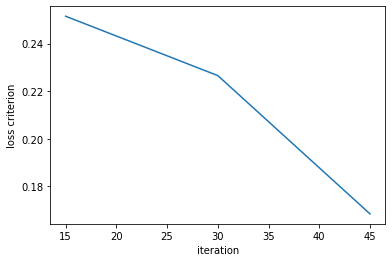

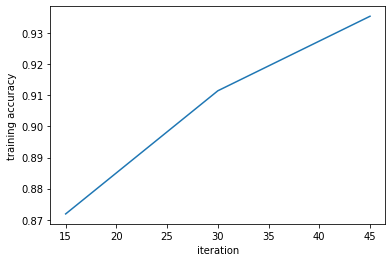

0.9354166666666667


In [18]:
plt.plot(logstep*np.arange(1,1+len(training_loss_vec)),np.array(training_loss_vec))
plt.ylabel("loss criterion")
plt.xlabel("iteration")
plt.show()
plt.plot(logstep*np.arange(1,1+len(training_accuracy_vec)),np.array(training_accuracy_vec))
plt.ylabel("training accuracy")
plt.xlabel("iteration")
plt.show()
print(max(training_accuracy_vec))

In [19]:
#https://www.kaggle.com/jaeboklee/pytorch-cat-vs-dog
testloader = datatorch.DataLoader(test_dataset, batch_size = 1, shuffle=False)

model.eval()
fn_list = []
pred_list = []
i = 0
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        
        
        pred = torch.argmax(output, dim=1)
       
        fn_list.append(fn.item())
        pred_list += [p.item() for p in pred]
        

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('submission8.csv', index=False)

In [20]:
print(len(fn_list))

6248


### model with 88.8% accuracy

model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            nn.Flatten(),
            torch.nn.Linear(9216, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 2),
            torch.nn.Sigmoid()
)
